## isolated clustering including recombination of mini-cluster for hpc run 

Comments:

ClusterGCN baseline, KDD 2020

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pickle
import shutil

from utils import *


In [3]:
import inspect
import torch
from torch_geometric.utils import scatter_

import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv
from sagegcn_conv_enhance import SAGEConv
from torch_geometric.utils import add_remaining_self_loops

### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [16, 16], dropout=0.3, improved = False, diag_lambda = -1):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.improved = improved 
        self.diag_lambda = diag_lambda
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        
        for i in range(len(self.input_layers)-1):
            self.layers.append(SAGEConv(self.input_layers[i], self.input_layers[i+1], 
                                       improved = self.improved, diag_lambda = self.diag_lambda, dropout = self.dropout))
        self.layers = ListModule(*self.layers)
        
        self.bn_layers = []
        for i in range(1, len(self.input_layers)):
            self.bn_layers.append(torch.nn.BatchNorm1d(self.input_layers[i]))
        self.bn_layers = ListModule(*self.bn_layers)

    # change the dropout positions: 
    def forward(self, edge_index, features):
        if len(self.layers) > 1:
            for i in range(len(self.layers)-1):
                features = self.layers[i](features, edge_index, dropout_training=self.training)
#                 features = F.dropout(features, p = self.dropout, training = self.training)
                features = self.bn_layers[i](features)
                features = F.relu(features)
            
            features = self.layers[len(self.layers)-1](features, edge_index, dropout_training=self.training)
        else:
            features = self.layers[0](features, edge_index, dropout_training=self.training)    # for a single layer case
        
        predictions = features
        # just use the linear layer output, since we are using the cross-entropy loss
        # just pay attention to the test part, change the predictions
        
#         predictions = F.log_softmax(features, dim=1)
        # if using the nll loss, then we need this log_softmax layer
        return predictions

### Partition GCN

In [31]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, tmp_folder = './tmp/', info_folder = './info/'):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        :tmp_folder(string): the path of the folder to contain all the clustering information files
        """
        self.features = features
        self.label = torch.tensor(label, dtype=torch.float)  # as required by the multi-label logic
        self._set_sizes()
        self.edge_index = edge_index
        # store the information folder for memory tracing
        self.tmp_folder = tmp_folder
        self.info_folder = info_folder
        
        tmp = edge_index.t().numpy().tolist()
        self.graph = nx.from_edgelist(tmp)
        
    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
        
    def split_whole_nodes_edges_then_cluster(self, validation_ratio, test_ratio, train_batch_num = 2, validation_batch_num = 2, test_batch_num = 2):
        """
            Only split nodes
            First create train-test splits, then split train and validation into different batch seeds
            Input:  
                1) ratio of validation (for convergnece), test
                2) partition number of train nodes, validation nodes (test nodes will be uses as a whole graph)
            Output:
                1) self.sg_validation_nodes_global, self.sg_train_nodes_global, self.sg_test_nodes_global
        """
        self.train_batch_num = train_batch_num
        relative_validation_ratio = (validation_ratio) / (1 - test_ratio)
        
        # first divide the nodes for the whole graph, result will always be a list of lists 
        model_nodes_global, self.test_nodes_global = train_test_split(list(self.graph.nodes()), test_size = test_ratio)
        train_nodes_global, self.validation_nodes_global = train_test_split(model_nodes_global, test_size = relative_validation_ratio)
        
        self.sg_train_nodes_global = self.random_clustering(train_nodes_global, train_batch_num)
        self.sg_validation_nodes_global = self.random_clustering(self.validation_nodes_global, validation_batch_num)
        self.sg_test_nodes_global = self.random_clustering(self.test_nodes_global, test_batch_num)

#         self.sg_train_nodes_global = self.metis_clustering(train_nodes_global, train_batch_num)
#         self.sg_validation_nodes_global = self.metis_clustering(validation_nodes_global, validation_batch_num)
        
    
    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        # randomly divide into two clusters
        nodes_order = [node for node in target_nodes]
        random.shuffle(nodes_order)
        n = (len(nodes_order) + partition_num - 1) // partition_num
        partition_list = [nodes_order[i * n:(i + 1) * n] for i in range(partition_num)]
#         cluster_membership = {node : i for i, node_list in enumerate(partition_list) for node in node_list}
        cluster_nodes_global = {i : node_list for i, node_list in enumerate(partition_list)}
        
        return cluster_nodes_global

    def metis_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        target_graph = self.graph.subgraph(target_nodes)
        (st, parts) = metis.part_graph(target_graph, partition_num)
        clusters = list(set(parts))
        cluster_nodes_global = defaultdict(list)
        for node, cluster_id in enumerate(parts):
            cluster_nodes_global[cluster_id].append(node)
        return cluster_nodes_global

    # for use of test on the whole graph as a whole in CPU-side memory
    def whole_batch_generate(self, batch_file_folder, test_nodes, batch_name = 'test_batch_whole'):
        """
            For use of testing the model: generate the needed tensors for testing in CPU-memory side
        """
        # store the global edges
        whole_nodes_global = sorted(self.graph.nodes())
        whole_edges_global = {edge for edge in self.graph.edges()}
        
        whole_edges_local = \
                       [ [ left, right ] for left, right in whole_edges_global ] + \
                       [ [ right, left ] for left, right in whole_edges_global ] + \
                       [ [i, i] for i in whole_nodes_global ]  
        
        # store local features and lables
        whole_features_local = self.features
        whole_labels_local = self.label

        # transform all the data to the tensor form
        whole_edges_local = torch.LongTensor(whole_edges_local).t()
        whole_features_local = torch.FloatTensor(whole_features_local)
        whole_labels_local = torch.FloatTensor(whole_labels_local)
        whole_test_nodes_local = torch.LongTensor( sorted(test_nodes) )

        whole_batch_data = [whole_test_nodes_local, whole_edges_local, whole_features_local, whole_labels_local]

        batch_file_name = batch_file_folder + batch_name

        # store the batch files
        t0 = time.time()
        with open(batch_file_name, "wb") as fp:
            pickle.dump(whole_batch_data, fp)
        store_time = ((time.time() - t0) * 1000)
        print('*** Generate batch file for # {0} batch, writing the batch file costed {1:.2f} ms ***'.format("whole graph", store_time) )
    
    
    def mini_batch_neighbor_sample(self, target_seed, sample_num = 10, layer_num = 2):
        """
            This function is to generate the neighbors of the seed (either train nodes or validation nodes)
            params: cluster index, number of layer k, fraction of sampling from each neighbor layer
            input: 
                1) target_seed: this is the 0 layer inside self.neighbor (can be either train or validation data)
                2) sample_num : number of sampling neighbor nodes around each seed; 
                    if negative, then include all the neighbors within layer_num of layers
            output:
                1) accum_neighbor: accumulating neighbors , i.e. the final batch nodes
        """
        accum_neighbor = defaultdict(set)
        
        if sample_num < 0:
            for cluster in target_seed.keys():
                pre_layer = set(target_seed[cluster])  # first layer of the neighbor nodes of each cluster
                accum_neighbor[cluster] |= pre_layer  # use the union instead of assignment here, avoid shallow copy issue
                for _ in range(layer_num):
                    curr_layer = set()
                    for node in pre_layer:
                        node_neigh = set(self.graph.neighbors(node))
                        curr_layer |= node_neigh
                    pre_layer = curr_layer - accum_neighbor[cluster]
                    accum_neighbor[cluster] |= pre_layer
        else:
            for cluster in target_seed.keys():
                neighbor = set(target_seed[cluster])  # first layer of the neighbor nodes of each cluster
                tmp_level = set()
                for node in neighbor:
                    node_neigh = set(self.graph.neighbors(node))
                    tmp_level |= set(random.sample(node_neigh, sample_num)) if len(node_neigh) > sample_num else node_neigh
                    # the key here we are using self.graph, extract neighbor from the whole graph
                accum_neighbor[cluster] |= neighbor | tmp_level
        
        return accum_neighbor
    
    def mini_batch_generate_tensor(self, target_batch_nodes, target_seed_nodes):
        """
            sampled_neighbor_nodes : selected neighbor nodes, to be combined with train seeds to form a train batch
            input: 
                1) target_batch_nodes: batch nodes including sampling neighbors around seed nodes 
                2) target_seed_nodes : seed nodes for forming neighbors (can be either train or validation data)
        """
        batch_subgraph = self.graph.subgraph(target_batch_nodes)
            
         # first select all the overlapping nodes of the train nodes
        mini_nodes_global = sorted(node for node in batch_subgraph.nodes())

        # store the global edges
        mini_edges_global = {edge for edge in batch_subgraph.edges()}

        # map nodes from global index to local index
        mini_mapper = {node: i for i, node in enumerate(mini_nodes_global)}

        # store local index of batch nodes
        mini_nodes_local = [ mini_mapper[global_idx] for global_idx in target_seed_nodes ]

        # store local index of batch edges
        mini_edges_local = \
                       [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in mini_edges_global ] + \
                       [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in mini_edges_global ] 

        # store local features and lables
        mini_features = self.features[mini_nodes_global,:]
        mini_labels = self.label[mini_nodes_global]
        
        # record information 
        info_batch_node_size = len(mini_nodes_global)
        info_batch_edge_size = len(mini_edges_local) + info_batch_node_size  # add the self-edges

        mini_nodes_local = torch.LongTensor(mini_nodes_local)
        mini_edges_local = torch.LongTensor(mini_edges_local).t()
        mini_features = torch.FloatTensor(mini_features)
        mini_labels = torch.FloatTensor(mini_labels)

        minibatch_data = [mini_nodes_local, mini_edges_local, mini_features, mini_labels]
        
        return minibatch_data, info_batch_node_size, info_batch_edge_size
    
    def mini_batch_generate(self, batch_file_folder, target_seed, sample_num = 10, layer_num = 2, batch_range = (0, 1)):
        """
            create the mini-batch focused on the train nodes only, include a total of k layers of neighbors of the original training nodes
            k: number of layers of neighbors for each training node
            fraction: fraction of neighbor nodes in each layer to be considered
            Input:
                1) target_seed: global ids of the nodes for seed to generate the batch (can be train or validation)
                2) sample_num : number of sampling nodes to be selected from each seed node's neighbors
            Output: all tensors which are gonna be used in the train, forward procedure
                local:
                    1) sg_mini_edges_local
                    2) self.sg_mini_train_nodes_local
                    3) self.sg_mini_train_features
                    4) self.sg_mini_train_labels
            
        """
        accum_neighbor = self.mini_batch_neighbor_sample(target_seed, sample_num = sample_num, layer_num = layer_num)
        batch_start, batch_end = batch_range
        
        info_batch_node_size = {}
        info_batch_edge_size = {}
        batch_start, batch_end = batch_range
        for cluster in range(batch_start, batch_end):
            # main purpose is to avoid too large size of this batch_subgraph with too many intra-edges inside
            
            minibatch_data, info_batch_node_size[cluster], info_batch_edge_size[cluster] = self.mini_batch_generate_tensor(accum_neighbor[cluster], target_seed[cluster])
            
            # store the batch files
            t0 = time.time()
            batch_file_name = batch_file_folder + 'batch_' + str(cluster)
            
            with open(batch_file_name, "wb") as fp:
                pickle.dump(minibatch_data, fp)
            store_time = ((time.time() - t0) * 1000)
            print('*** Generate batch file for # {0:3d} batch, writing the batch file costed {1:.2f} ms ***'.format(cluster, store_time) )
#             print('writing to the path: ', batch_file_name)
            
        return info_batch_node_size, info_batch_edge_size
    
    
    def save_info_dict(self, data, file_name, target_folder, header = 'key, value'):
        # output the batch size information as the csv file
#         os.makedirs(os.path.dirname(target_folder), exist_ok=True)
        target_file = target_folder + file_name
        with open(target_file, 'a', newline='\n') as fp:
            wr = csv.writer(fp, delimiter = ',')
            fp.write('\n')
            wr.writerow(header.split(','))
            for key, val in data.items():
                if isinstance(val, list):
                    wr.writerow([key+1] + val)
                else:
                    wr.writerow([key+1, val])
                    
    def mini_batch_train_clustering(self, batch_folder, sample_num = 10, layer_num = 2, batch_range = (0, 1), info_folder = './info/', info_file = 'train_batch_size_info.csv'):
        data_type = 'train'
        batch_file_folder = batch_folder + '{}_batch/'.format(data_type)
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_train_batch_node_size, self.info_train_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_train_nodes_global, sample_num = sample_num, layer_num = layer_num, batch_range = batch_range)
        self.info_train_seed_size = {key : len(val) for key, val in self.sg_train_nodes_global.items()}
        
        self.save_info_dict(self.info_train_batch_node_size, info_file, info_folder, header = 'train_batch_node_id, train_batch_node_size')
        self.save_info_dict(self.info_train_batch_edge_size, info_file, info_folder, header = 'train_batch_edge_id, train_batch_edge_size')
        self.save_info_dict(self.info_train_seed_size, info_file, info_folder, header = 'train_seed_node_id, train_seed_node_size')
        
        
    def mini_batch_validation_clustering(self, batch_folder, sample_num = -1, layer_num = 2, batch_range = (0, 1), info_folder = './info/', info_file = 'validation_batch_size_info.csv'):
        data_type = 'validation'
        batch_file_folder = batch_folder + '{}_batch/'.format(data_type)
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_validation_batch_node_size, self.info_validation_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_validation_nodes_global, sample_num = sample_num, layer_num = layer_num, batch_range = batch_range)
        self.info_validation_seed_size = {key : len(val) for key, val in self.sg_validation_nodes_global.items()}
        
        self.save_info_dict(self.info_validation_batch_node_size, info_file, info_folder, header = 'validation_batch_node_id, validation_batch_node_size')
        self.save_info_dict(self.info_validation_batch_edge_size, info_file, info_folder, header = 'validation_batch_edge_id, validation_batch_edge_size')
        self.save_info_dict(self.info_validation_seed_size, info_file, info_folder, header = 'validation_seed_node_id, validation_seed_node_size')
        
    def mini_batch_test_clustering(self, batch_folder, sample_num = -1, layer_num = 2, batch_range = (0, 1), info_folder = './info/', info_file = 'test_batch_size_info.csv'):
        data_type = 'test'
        batch_file_folder = batch_folder + '{}_batch/'.format(data_type)
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_test_batch_node_size, self.info_test_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_test_nodes_global, sample_num = sample_num, layer_num = layer_num, batch_range = batch_range)
        self.info_test_seed_size = {key : len(val) for key, val in self.sg_test_nodes_global.items()}
        
        self.save_info_dict(self.info_test_batch_node_size, info_file, info_folder, header = 'test_batch_node_id, test_batch_node_size')
        self.save_info_dict(self.info_test_batch_edge_size, info_file, info_folder, header = 'test_batch_edge_id, test_batch_edge_size')
        self.save_info_dict(self.info_test_seed_size, info_file, info_folder, header = 'test_seed_node_id, test_seed_node_size')

    
    def whole_test_clustering(self, batch_folder, info_folder = './info/'):
        data_type = 'test'
        batch_file_folder = batch_folder + '{}_batch/'.format(data_type)
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.whole_batch_generate(batch_file_folder, self.test_nodes_global, batch_name = data_type + '_batch_whole')        
        
        
    def whole_validation_clustering(self, batch_folder, info_folder = './info/'):
        data_type = 'validation'
        batch_file_folder = batch_folder + '{}_batch/'.format(data_type)
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.whole_batch_generate(batch_file_folder, self.validation_nodes_global, batch_name = data_type + '_batch_whole')   

#### Partition Graph with trainiing and testing

In [32]:
# from Custom_GCN_layer import Net
import time
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, data_folder, in_channels, out_channels, input_layers = [32, 16], dropout=0.3, improved = False, diag_lambda = -1):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.test_device = torch.device("cpu")
        
        self.data_folder = data_folder
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.improved = improved
        self.diag_lambda = diag_lambda
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, 
                         dropout = self.dropout, improved = self.improved, diag_lambda = self.diag_lambda)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, tr_train_nodes, tr_edges, tr_features, tr_target):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(tr_edges, tr_features)
        _loss = torch.nn.BCEWithLogitsLoss()
        ave_loss = _loss(predictions[tr_train_nodes], tr_target[tr_train_nodes])
#         ave_loss = torch.nn.functional.nll_loss(predictions[tr_train_nodes], tr_target[tr_train_nodes])
        node_count = tr_train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count

    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item() * node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss
    
    def train_investigate_F1(self, tune_model_folder, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, output_period = 10, train_batch_num = 2):
        """
            *** Periodically output the F1 score during training. After certain number of epochs ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
            output_period:  number of epochs after which output the F1 and accuray to investigate the model refining process
        """
        os.makedirs(os.path.dirname(tune_model_folder), exist_ok=True)
        model_snapshot_list = []
        
        # start the training investigation
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()   #   set into train mode, only effective for certain modules such as dropout and batchNorm
        self.record_ave_training_loss = []
        
        self.time_train_load_data = 0
        total_train_data_IO_time = 0
        total_validation_processing_time = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch_part in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                
                # 1) readin the train node batch data
                train_batch_file_name = self.data_folder + 'train_batch/batch_' + str(cluster)
                
                t2 = time.time()
                with open(train_batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                total_train_data_IO_time += (time.time() - t2) * 1000
                
                tr_train_nodes, tr_edges, tr_features, tr_target = minibatch_data_train
                
                # for each cluster, we load once and train it for multiple epochs:
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                
                                
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    self.node_count_seen = 0
                    self.accumulated_training_loss = 0

                    # record the current overall epoch index:
                    real_epoch_num = 1 + mini_epoch + mini_epoch_num * epoch_part # real_epoch_num starts from 0, therefore we add 1

                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    self.record_ave_training_loss.append(ave_loss)

                    # at this point finish a single train duration: update the parameter and calcualte the loss function
                    # periodically output the F1-score in the middle of the training process
                    if real_epoch_num % output_period == 0:
                        test_model = self.model.to(self.test_device)
                        test_model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
                        
                        model_snapshot_list.append(real_epoch_num)
                        tune_model_file_name = tune_model_folder + 'model_epoch_' + str(real_epoch_num)
                        with open(tune_model_file_name, "wb") as fp:
                            pickle.dump(test_model, fp)
                        
                        # this to func is change in-place: need to restore the state:
                        self.model = self.model.to(self.device)
                        self.model.train()
            
        # convert to ms
        print('*** During training, reading all batch file I/O costed {0:.2f} ms ***'.format(total_train_data_IO_time) )
        self.time_train_total = ((time.time() - t0) * 1000) - total_train_data_IO_time - total_validation_processing_time
        
        tune_model_list_name = tune_model_folder + 'model_index'
        with open(tune_model_list_name, "wb") as fp:
                            pickle.dump(model_snapshot_list, fp)
        
    
    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, train_batch_num = 2):
        """
            *** Training a model. ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        self.record_ave_training_loss = []
        # record the data uploading to GPU time, and the data IO time for each train batch
        self.time_train_load_data = 0
        total_data_IO_time = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train_batch/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                total_data_IO_time += (time.time() - t2) * 1000
                
                tr_train_nodes, tr_edges, tr_features, tr_target = minibatch_data_train
                
                # for each cluster, we load once and train it for multiple epochs:
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    self.node_count_seen = 0
                    self.accumulated_training_loss = 0
                    
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    # record training loss per epoch
                    self.record_ave_training_loss.append(ave_loss)
            
        # convert to ms
        print('*** During training, total IO data reading time for all batches costed {0:.2f} ms ***'.format(total_data_IO_time) )
        self.time_train_total = ((time.time() - t0) * 1000) - total_data_IO_time
    
    def distr_cpu_eval(self, batch_ids = [0]):
        """
            Scoring the test and printing the F-1 score.
        """
        self.test_device = torch.device("cpu")
        test_model = self.model.to(self.test_device)
        test_model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        eval_folder = self.data_folder + 'test_batch/'
        
        targets_list, predictions_list = [], []
        
        for batch_id in batch_ids:
            batch_file_name = eval_folder + "batch_" + str(batch_id)

            t2 = time.time()
            with open(batch_file_name, "rb") as fp:
                minibatch_data_test = pickle.load(fp)
            read_time = (time.time() - t2) * 1000
            print('*** During test for # {0} batch, reading batch file costed {1:.2f} ms ***'.format(batch_id, read_time) )

            test_nodes, test_edges, test_features, test_target = minibatch_data_test

            # select the testing nodes predictions and real labels
            y_pred = test_model(test_edges, test_features)[test_nodes]
            # for multi-label task, first use the sigmoid function and rounding to 0, 1.0 labels
            y_pred_tag = (torch.sigmoid(y_pred)).round()
            targets = test_target[test_nodes].cpu().detach().numpy()
            predictions = y_pred_tag.cpu().detach().numpy()
            
            targets_list.append(targets)
            predictions_list.append(predictions)
        
        all_targets = np.concatenate(targets_list, axis = 0)
        all_predictions = np.concatenate(predictions_list, axis = 0)
        
        f1 = f1_score(all_targets, all_predictions, average="micro")
        accuracy = binary_acc(all_targets, all_predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)
    
    def whole_cpu_test(self):
        """
            Scoring the test and printing the F-1 score.
        """
        self.test_device = torch.device("cpu")
        test_model = self.model.to(self.test_device)
        test_model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        batch_file_name = self.data_folder + 'test/test_batch_whole'

        t2 = time.time()
        with open(batch_file_name, "rb") as fp:
            minibatch_data_test = pickle.load(fp)
        read_time = (time.time() - t2) * 1000
        print('*** During test for # {0} batch, reading batch file costed {1:.2f} ms ***'.format("whole graph", read_time) )

        test_nodes, test_edges, test_features, test_target = minibatch_data_test

        # select the testing nodes predictions and real labels
        y_pred = test_model(test_edges, test_features)[test_nodes]
        # for multi-label task, first use the sigmoid function and rounding to 0, 1.0 labels
        y_pred_tag = (torch.sigmoid(y_pred)).round()
        predictions = y_pred_tag.cpu().detach().numpy()
        
        targets = test_target[test_nodes].cpu().detach().numpy()
        
        f1 = f1_score(targets, predictions, average="micro")
#       accuracy = accuracy_score(targets.flatten(), predictions.flatten())   # for multi-class task, here have to be flatten first
        accuracy = binary_acc(targets, predictions)    # for multi-label task
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)
    


### Use Trivial data

In [38]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label = torch.tensor([[0, 1], [1, 0], [1, 1], [1, 0], [0, 0], [0, 1], [1, 0], [1, 1], [1, 0], [0, 0]], dtype = torch.float)
print(features, features.shape)

# set the tmp folder
# tmp_folder = './tmp/'
# check_folder_exist(tmp_folder)
# os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
# set the store clustering path
tmp_folder = './res_save_batch/tmp/'
check_folder_exist(tmp_folder)
clustering_file_name = tmp_folder + 'check_clustering_machine.txt'
os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
info_folder = './res_save_batch/info/'
check_folder_exist(info_folder)
os.makedirs(os.path.dirname(info_folder), exist_ok=True)


node_count = features.shape[0]
clustering_machine = ClusteringMachine(edge_index, features, label)
clustering_machine.split_whole_nodes_edges_then_cluster(0.4, 0.4, train_batch_num = 2, validation_batch_num = 2)
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after split: ')

with open(clustering_file_name, "wb") as fp:
    pickle.dump(clustering_machine, fp)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### minibatch train nodes and batch validatioin 

In [39]:

mini_batch_folder = './res_save_batch/mini_batch_files/'
check_folder_exist(mini_batch_folder)

with open(clustering_file_name, "rb") as fp:
    clustering_machine = pickle.load(fp)

# generate the batches for train and validation
clustering_machine.mini_batch_train_clustering(mini_batch_folder, sample_num = 10, batch_range = (0, 2), info_folder = info_folder) # include number of layers
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after train clustering: ')

clustering_machine.mini_batch_validation_clustering(mini_batch_folder, sample_num = -1, layer_num = 2, batch_range = (0, 2), info_folder = info_folder) # include number of layers
clustering_machine.mini_batch_test_clustering(mini_batch_folder, sample_num = -1, layer_num = 2, batch_range = (0, 2), info_folder = info_folder) # include number of layers

# clustering_machine.whole_test_clustering(mini_batch_folder, info_folder = info_folder)
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after test clustering:  ')

# construct the batch trainer
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(mini_batch_folder, 2, 2, input_layers = [16], dropout=0.3)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after generating trainer:  ')

gcn_trainer_batch.train(1, 0.0001, 0.1, train_batch_num = 2)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after training the batch:  ')

# gcn_trainer_batch.batch_validate(valid_batch_num = 2)

gcn_trainer_batch.distr_cpu_eval(batch_ids = [0, 1])
output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after validating the batch:  ')

*** Generate batch file for #   0 batch, writing the batch file costed 0.29 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.24 ms ***
*** Generate batch file for #   0 batch, writing the batch file costed 0.23 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.20 ms ***
*** Generate batch file for #   0 batch, writing the batch file costed 0.20 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.19 ms ***
*** During training, total IO data reading time for all batches costed 0.69 ms ***
*** During test for # 0 batch, reading batch file costed 0.26 ms ***
*** During test for # 1 batch, reading batch file costed 0.24 ms ***


### basic execution

In [52]:
''' Execute the testing program '''
def set_clustering_machine(data, dataset, intermediate_data_folder, validation_ratio = 0.05, test_ratio = 0.85, train_batch_num = 2, validation_batch_num = 2):
    """
        Set the batch machine plus generate the training batches
            1) data: the target dataset data
            2) intermediate_data_folder: path to store the intermediate generated data
            3) test_ratio, validation_ratio: data split ratio
            4) train_batch_num :  batch number for train
    """
    # set the tmp file for garbage tmp files, just collect the info:
    tmp_folder = intermediate_data_folder + 'tmp/'
    check_folder_exist(tmp_folder)
    os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
    
    # Set the clustering information storing path
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    check_folder_exist(clustering_file_folder)  # if exist then delete
    check_folder_exist(data_info_file_folder)  # if exist then delete
    
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    data_info_file_name = data_info_file_folder + 'data_info_file.txt'
    os.makedirs(os.path.dirname(clustering_file_folder), exist_ok=True)
    os.makedirs(os.path.dirname(data_info_file_folder), exist_ok=True)
    

    print('\n' + '=' * 100)
    print('Start to generate the clustering machine:')
    t0 = time.time()
    # if we use the random assignment of the code, then filtering out the isolated data may not be necessary
    connect_edge_index, connect_features, connect_label = filter_out_isolate_normalize_feature(data.edge_index, data.x, data.y)
    clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label, tmp_folder)
    
#     clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder)
    batch_machine_create = time.time() - t0
    print('Batch machine creation costs a total of {0:.4f} seconds!'.format(batch_machine_create))
    
    node_count = connect_features.shape[0]
    feature_count = connect_features.shape[1]    # features all always in the columns
    edge_count = connect_edge_index.shape[1]
    print('\nEdge number: ', edge_count, '\nNode number: ', node_count, '\nFeature number: ', feature_count) 
    
    # at last output the information inside the folder:
    print_dir_content_info(tmp_folder)
    
#     clustering_machine.split_cluster_nodes_edges(test_ratio, validation_ratio, partition_num = train_batch_num)
    # mini-batch only: split to train test valid before clustering
    print('Start to split data into train, test, validation:')
    t1 = time.time()
    clustering_machine.split_whole_nodes_edges_then_cluster(validation_ratio, test_ratio, train_batch_num = train_batch_num, validation_batch_num = validation_batch_num)
    data_split_time = time.time() - t1
    print('Data splitting costs a total of {0:.4f} seconds!'.format(data_split_time))
    
    print('Start to store the batch machine file:')
    t3 = time.time()
    with open(clustering_file_name, "wb") as fp:
        pickle.dump(clustering_machine, fp)
    
    # data number we requred are the feature number and the classes, note after the filtering, the node number may be smaller by removing isolated nodes
    data_info = (dataset.num_node_features, dataset.num_classes )
    with open(data_info_file_name, "wb") as fp:
        pickle.dump(data_info, fp)

    batch_machine_store_time = time.time() - t3
    print('Storing batch machine after training batches generation costs a total of {0:.4f} seconds!'.format(batch_machine_store_time))
    print('\n' + '=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_setting_cluster.txt', info_GPU_memory_folder, comment ='after setting clustering machine: ')
    
def set_clustering_machine_train_batch(intermediate_data_folder, sample_num = 10, \
                                      batch_range = (0, 1), info_folder = 'info_train_batch/', info_file = 'train_batch_size_info.csv'):
    """
        Generate the train batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
#     check_folder_exist(intermediate_data_folder)  # if exist then delete
    print('Start to generate the training batches:')
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t2 = time.time()
    clustering_machine.mini_batch_train_clustering(intermediate_data_folder, sample_num = sample_num,
                                                   batch_range = batch_range, info_folder = info_folder, info_file = info_file)
    train_batch_production_time = time.time() - t2
    print('Train batches production costs a total of {0:.4f} seconds!'.format(train_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'train_batch/')
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_cost_setting_train_batch.txt', info_GPU_memory_folder, comment ='after generating train batches: ')

def set_clustering_machine_eval_batch(intermediate_data_folder, sample_num = 10, layer_num = 2, eval_type = "validation",
                                      batch_range = (0, 1), info_folder = 'info_eval_batch/'):
    """
        Generate the test batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    
    ### ============= eval batches =================
    print('Start to generate the test batches:')
    t2 = time.time()
    if eval_type == "validation":
        clustering_machine.mini_batch_validation_clustering(intermediate_data_folder, sample_num = sample_num, layer_num = layer_num,
                                                   batch_range = batch_range, info_folder = info_folder, info_file = "{}_batch_size_info.csv".format(eval_type))
    elif eval_type == "test":
        clustering_machine.mini_batch_test_clustering(intermediate_data_folder, sample_num = sample_num, layer_num = layer_num,
                                                   batch_range = batch_range, info_folder = info_folder, info_file = "{}_batch_size_info.csv".format(eval_type))
    else:
        assert("eval type can only be either validation or test")
    
    eval_batch_production_time = time.time() - t2
    print('{0} batches production costs a total of {1:.4f} seconds!'.format(eval_type, eval_batch_production_time))
    print_dir_content_info(intermediate_data_folder + "{}_batch/".format(eval_type))
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_cost_setting_{}_batch.txt'.format(eval_type), info_GPU_memory_folder, comment ='after generating {} batches: '.format(eval_type))

def set_clustering_machine_batch_whole_graph(intermediate_data_folder, info_folder = 'info_batch_whole_graph/'):
    """
        Generate the test for the whole graph
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    print('Start to generate the test whole graph:')
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t1 = time.time()
    
    # create the test batch for the whole graph
    clustering_machine.whole_test_clustering(intermediate_data_folder, info_folder = info_folder + 'test_batch/')
    # create the validation batch for the whole graph
    clustering_machine.whole_validation_clustering(intermediate_data_folder, info_folder = info_folder + 'validation_batch/')
    
    test_batch_production_time = time.time() - t1
    print('Test batches production costs a total of {0:.4f} seconds!'.format(test_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'test/')
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_memory_cost_generate_validatoin_data.txt', info_GPU_memory_folder, comment ='after generating test for whole graph: ')
    


In [78]:
def Cluster_investigate_train(tune_model_folder, intermediate_data_folder, input_layer = [16, 16], epochs=300,
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, improved = False, diag_lambda = -1, 
                              output_period = 10, train_part_num = 2):
    """
        *** dynamically investigate the F1 score in the middle of the training after certain period ***
        output: two dict containing F1-score and accuracy of a certain epoch index
    """
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    data_info_file = data_info_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, 
                                               dropout = dropout, improved = improved, diag_lambda = diag_lambda)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    
    gcn_trainer.train_investigate_F1(tune_model_folder, epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num,
                                                            output_period = output_period, train_batch_num = train_part_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    print('-' * 80)
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_train_batch_investigate.txt', info_GPU_memory_folder, comment ='after train batch investigate: ')
    
    return gcn_trainer.time_train_total, gcn_trainer.time_train_load_data


def Cluster_investigate_evaluation(validation_model, mini_batch_folder, eval_target = 'validation/validation_batch_whole'):
    """
        Evaluation func:
        Use the validation whole batch for validation
        Use the test whole batch for test
    """
    batch_file_name = mini_batch_folder + eval_target

    with open(batch_file_name, "rb") as fp:
        minibatch_data_test = pickle.load(fp)

    test_nodes, test_edges, test_features, test_target = minibatch_data_test

    # select the testing nodes predictions and real labels
    y_pred = validation_model(test_edges, test_features)[test_nodes]
    # for multi-label task, first use the sigmoid function and rounding to 0, 1.0 labels
    y_pred_tag = (torch.sigmoid(y_pred)).round()
    predictions = y_pred_tag.cpu().detach().numpy()

    targets = test_target[test_nodes].cpu().detach().numpy()

    f1 = f1_score(targets, predictions, average="micro")
#       accuracy = accuracy_score(targets.flatten(), predictions.flatten())   # for multi-class task, here have to be flatten first
    accuracy = binary_acc(targets, predictions)    # for multi-label task
#         print("\nTest F-1 score: {:.4f}".format(score))
    return (f1, accuracy)

def Cluster_investigate_evaluation_scatter_distr(eval_model, working_folder, distr_eval_folder, eval_type = "validation", batch_ids = [0]):
    """
        Distributed version of evaluation func:
            Use the validation batches inside validation_batch_distr for validation
            Use the test batches inside eval_batch_distr for evaling
    """
    
    eval_batch_folder = working_folder + '{}_batch/'.format(eval_type)
    os.makedirs(os.path.dirname(distr_eval_folder), exist_ok=True)
    
    for batch_id in batch_ids:
        batch_file_name = eval_batch_folder + "batch_" + str(batch_id)

        with open(batch_file_name, "rb") as fp:
            minibatch_data_eval = pickle.load(fp)

        eval_nodes, eval_edges, eval_features, eval_target = minibatch_data_eval
        
        # select the evaluation nodes predictions and real labels
        y_pred = eval_model(eval_edges, eval_features)[eval_nodes]
        # for multi-label task, first use the sigmoid function and rounding to 0, 1.0 labels
        y_pred_tag = (torch.sigmoid(y_pred)).round()
        predictions = y_pred_tag.cpu().detach().numpy()
        targets = eval_target[eval_nodes].cpu().detach().numpy()

        eval_distr_val_file = "{}eval_batch_{}".format(distr_eval_folder, batch_id)
        with open(eval_distr_val_file, "wb") as fp:
            pickle.dump((targets, predictions), fp)


def Cluster_investigate_evaluation_aggr_distr(working_folder, distr_eval_folder, eval_type = "validation", batch_ids = [0]):
    
    targets_list, predictions_list = [], []
    
    for batch_id in batch_ids:
        eval_distr_val_file = "{}eval_batch_{}".format(distr_eval_folder, batch_id)
        
        with open(eval_distr_val_file, "rb") as fp:
            targets, predictions = pickle.load(fp)
        
        targets_list.append(targets)
        predictions_list.append(predictions)
    
    all_targets = np.concatenate(targets_list, axis = 0)
    all_predictions = np.concatenate(predictions_list, axis = 0)
    
    f1 = f1_score(all_targets, all_predictions, average="micro")
    accuracy = binary_acc(all_targets, all_predictions)
    
    return f1, accuracy

###  Investigate the F1 score during training

In [79]:

### ======== Investigate F1-score offline
def execute_investigate_train(mini_batch_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0, input_layer = [32], epoch_num = 300,
                        dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 20, improved = False, diag_lambda = -1,
                        output_period = 10, train_part_num = 2):
    """
        return all validation-F1 for all four models
    """
    # store the resulting data on the disk
    tune_model_folder = mini_batch_folder + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + '/model_trainer_' + str(trainer_id) + '/'
    os.makedirs(os.path.dirname(tune_model_folder), exist_ok=True)
    
    time_res = Cluster_investigate_train(tune_model_folder, mini_batch_folder, input_layer = input_layer, epochs=epoch_num,
                                          dropout = dropout, lr = tune_val, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, 
                                         improved = improved, diag_lambda = diag_lambda,
                                          output_period = output_period, train_part_num = train_part_num)
    
    time_res_folder = mini_batch_folder + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/validation_trainer_' + str(trainer_id) + '/'
    os.makedirs(os.path.dirname(time_res_folder), exist_ok=True)
    
    time_res_file_name = time_res_folder + 'time_total_and_load'
    with open(time_res_file_name, "wb") as fp:
        pickle.dump(time_res, fp)


def execute_investigate_validation(image_path, mini_batch_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0, model_epoch = [1]):
    """
        return all validation-F1 for all four models
    """
    # store the resulting data on the disk
    tune_model_folder = mini_batch_folder + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + '/model_trainer_' + str(trainer_id) + '/'
    
    res_model_folder = mini_batch_folder + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/validation_trainer_' + str(trainer_id) + '/'
    os.makedirs(os.path.dirname(res_model_folder), exist_ok=True)
    
    for validation_epoch in model_epoch:
        tune_model_file_name = tune_model_folder + 'model_epoch_' + str(validation_epoch)
        with open(tune_model_file_name, "rb") as fp:
            validation_model = pickle.load(fp)
        
        res = Cluster_investigate_evaluation(validation_model, mini_batch_folder)
        # saved the validation results, later can be used in the testing step to choose the trained_model_epoch best validation-F1 score to generate the Test-F1 score
        res_model_file_name = res_model_folder + 'model_epoch_' + str(validation_epoch)
        with open(res_model_file_name, "wb") as fp:
            pickle.dump(res, fp)


#### Distributed version of the validation F1-score

In [80]:
def execute_investigate_validation_scatter_distr(working_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0, 
                                                 model_epoch = [1], batch_ids = [0]):
    """
        generate the partial evaluation results from batches of subgraphs
    """
    tune_model_folder = working_folder + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + '/model_trainer_' + str(trainer_id) + '/'
    record_eval_folder = "{}validation_distr_eval_res/tune_{}_{}/trainer_{}/".format(working_folder, tune_param_name, tune_val_label, trainer_id)
    for validation_epoch in model_epoch:
        tune_model_file_name = tune_model_folder + 'model_epoch_' + str(validation_epoch)
        with open(tune_model_file_name, "rb") as fp:
            validation_model = pickle.load(fp)
        
        distr_eval_folder = "{}model_epoch_{}/".format(record_eval_folder, validation_epoch)
        
        os.makedirs(os.path.dirname(distr_eval_folder), exist_ok=True)
        # generate the evaluation for each validation batch cut from the whole graph
        Cluster_investigate_evaluation_scatter_distr(validation_model, working_folder, distr_eval_folder, eval_type = "validation", batch_ids = batch_ids)
        
def execute_investigate_validation_aggr_distr(working_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0, 
                                              model_epoch = [1], batch_ids = [0]):
    """
        Aggregate the evaluation results from the validation of graph batches
    """
    
    res_model_folder = working_folder + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/validation_trainer_' + str(trainer_id) + '/'
    os.makedirs(os.path.dirname(res_model_folder), exist_ok=True)
    
    record_eval_folder = "{}validation_distr_eval_res/tune_{}_{}/trainer_{}/".format(working_folder, tune_param_name, tune_val_label, trainer_id)
    
    for validation_epoch in model_epoch:
        distr_eval_folder = "{}model_epoch_{}/".format(record_eval_folder, validation_epoch)
        res = Cluster_investigate_evaluation_aggr_distr(working_folder, distr_eval_folder, eval_type = "validation", batch_ids = batch_ids)
        # saved the validation results, later can be used in the testing step to choose the trained_model_epoch best validation-F1 score to generate the Test-F1 score
        res_model_file_name = res_model_folder + 'model_epoch_' + str(validation_epoch)
        with open(res_model_file_name, "wb") as fp:
            pickle.dump(res, fp)

### Investigate the test-F1 score

In [81]:
### ======== Investigate test-score offline
def execute_test_tuning(image_path, mini_batch_folder, snapshot_epoch_list,
                        tune_param_name, tune_val_label, tune_val, trainer_id = 0):
    """
        1) After the validation, select the epoch with the best validation score
        2) use the trained model at the selected optimal epoch of validation
        3) perform the evaluate func for the test data
    """
    # start to search for the trained model epoch with the best validation f1 socre
    f1mic_best, ep_best = 0, -1
    
    validation_res_folder = mini_batch_folder + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/validation_trainer_' + str(trainer_id) + '/'
    
    for validation_epoch in snapshot_epoch_list:
        validation_res_file_name = validation_res_folder + 'model_epoch_' + str(validation_epoch)
        with open(validation_res_file_name, "rb") as fp:
            f1mic_val, accuracy_val = pickle.load(fp)
            
        if f1mic_val > f1mic_best:
            f1mic_best, ep_best = f1mic_val, validation_epoch
        
    # use the selected model to perform on the test
    tune_model_folder = mini_batch_folder + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    # save the selected best saved snapshot
    best_model_file = tune_model_folder + 'model_epoch_' + str(ep_best)
    shutil.copy2(best_model_file, tune_model_folder + 'best_saved_snapshot.pkl')
    
    with open(best_model_file, "rb") as fp:
        best_model = pickle.load(fp)
    
    f1, accuracy = Cluster_investigate_evaluation(best_model, mini_batch_folder, eval_target = 'test/test_batch_whole')
    
    # store the resulting data on the disk
    test_res_folder = mini_batch_folder + 'test_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump((f1, accuracy), fp)

#### Distributed version of test F1-score

In [82]:
def execute_test_tuning_scatter_distr(working_folder, snapshot_epoch_list, tune_param_name, tune_val_label, tune_val, 
                                      trainer_id = 0, batch_ids = [0]):
    """
        1) After the validation, select the epoch with the best validation score
        2) use the trained model at the selected optimal epoch of validation
        3) perform the evaluate func for the test data
    """
    # start to search for the trained model epoch with the best validation f1 socre
    f1mic_best, ep_best = 0, -1
    
    validation_res_folder = working_folder + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/validation_trainer_' + str(trainer_id) + '/'
    
    for validation_epoch in snapshot_epoch_list:
        validation_res_file_name = validation_res_folder + 'model_epoch_' + str(validation_epoch)
        with open(validation_res_file_name, "rb") as fp:
            f1mic_val, accuracy_val = pickle.load(fp)
            
        if f1mic_val > f1mic_best:
            f1mic_best, ep_best = f1mic_val, validation_epoch
        
    # use the selected model to perform on the test
    tune_model_folder = working_folder + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    # save the selected best saved snapshot
    best_model_file = tune_model_folder + 'model_epoch_' + str(ep_best)
    shutil.copy2(best_model_file, tune_model_folder + 'best_saved_snapshot.pkl')
    
    with open(best_model_file, "rb") as fp:
        best_model = pickle.load(fp)
    
    ### ============== After choosing the best model from validation
    distr_test_folder = "{}test_distr_eval_res/tune_{}_{}/trainer_{}/".format(working_folder, tune_param_name, tune_val_label, trainer_id)
    os.makedirs(os.path.dirname(distr_test_folder), exist_ok=True)
    
    Cluster_investigate_evaluation_scatter_distr(best_model, working_folder, distr_test_folder, eval_type = "test", batch_ids = batch_ids)


def execute_test_tuning_aggr_distr(working_folder, tune_param_name, tune_val_label, tune_val, 
                                   trainer_id = 0, batch_ids = [0]):
    distr_test_folder = "{}test_distr_eval_res/tune_{}_{}/trainer_{}/".format(working_folder, tune_param_name, tune_val_label, trainer_id)
    
    f1, accuracy = Cluster_investigate_evaluation_aggr_distr(working_folder, distr_test_folder, eval_type = "test", batch_ids = batch_ids)
    
    # store the resulting data on the disk
    test_res_folder = working_folder + 'test_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump((f1, accuracy), fp)

### Separate steps of HPC execution for one single task

In [83]:
def step0_generate_clustering_machine(data, dataset, intermediate_data_path, train_batch_num = 2, validation_batch_num = 2, \
                                      validation_ratio = 0.05, test_ratio = 0.85):            
    print('Start running for train batch num: ' + str(train_batch_num) )

    # set the basic settings for the future batches generation
    set_clustering_machine(data, dataset, intermediate_data_path, validation_ratio = validation_ratio, test_ratio = test_ratio, \
                           train_batch_num = train_batch_num, validation_batch_num = validation_batch_num)

def step1_generate_train_batch(intermediate_data_path, sample_num = 10, \
                               batch_range = (0, 1), info_folder = 'info/'):            
    # set the save path
    print('Start running for train batch num: ' + str(batch_range) )
    info_file = 'train_batch_size_info_{}.csv'.format(str(batch_range))

    # generate the train batches
    set_clustering_machine_train_batch(intermediate_data_path, sample_num = sample_num, \
                                       batch_range = batch_range, info_folder = info_folder, info_file = info_file)

def step2_generate_batch_whole_graph(intermediate_data_path, info_folder = 'info/'): 
    """
        generate all the tensors from the  whole graph for validattion and test
    """
    set_clustering_machine_batch_whole_graph(intermediate_data_path, info_folder = info_folder)
            


### Separate steps for investigation training

In [84]:
def step31_run_investigation_train_batch(intermediate_data_path, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, GCN_layer, \
                    trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, improved = False, diag_lambda = -1,
                                         epoch_num = 400, output_period = 40):            
    # start to tune the model, and investigate the performance in the middle
    print('Start running investigation traing for train batch num: ' + str(train_batch_num) + ' for_trainer_id_' + str(trainer_id))
    execute_investigate_train(intermediate_data_path, tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id, input_layer = GCN_layer, epoch_num = epoch_num, \
                    dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, improved = improved, diag_lambda = diag_lambda, \
                              output_period = output_period, train_part_num = train_batch_num)

def step41_run_investigation_validation_batch(image_data_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, \
                    trainer_id = 0, model_epoch = [1]):
    
    print('Start running investigation validation for train batch num: ' + str(train_batch_num) + ' for_trainer_id_' + str(trainer_id))
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    
    execute_investigate_validation(img_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id, model_epoch = model_epoch)


In [85]:
def step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_label_list, tune_val_list, \
                                    train_batch_num, net_layer_num, trainer_list): 
    
    print('Start running training for partition num: ' + str(train_batch_num))
    # set the batch for test and train
    img_path = image_data_path + 'test_res/'  # further subfolder for different task

    # start to summarize the results into images for output

    test_f1, test_accuracy, time_total_train, time_data_load = summarize_tuning_res(img_path, intermediate_data_path, tune_param_name, tune_val_label_list, tune_val_list, trainer_list)

    generate_tuning_raw_data_table(test_accuracy, img_path, 'test_acc.csv', tune_param_name)
    test_accuracy_file = store_data_multi_tuning(tune_val_list, test_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(test_accuracy_file, data_name, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Accuracy')

    generate_tuning_raw_data_table(test_f1, img_path, 'test_f1.csv', tune_param_name)
    test_f1_file = store_data_multi_tuning(tune_val_list, test_f1, data_name, img_path, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(test_f1_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'F1 score')

    generate_tuning_raw_data_table(time_total_train, img_path, 'time_train_total.csv', tune_param_name)
    time_train_file = store_data_multi_tuning(tune_val_list, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(time_train_file, data_name, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Train Time (ms)')

    generate_tuning_raw_data_table(time_data_load, img_path, 'time_load_data.csv', tune_param_name)
    time_load_file = store_data_multi_tuning(tune_val_list, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(time_load_file, data_name, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Load Time (ms)')
 
def step51_run_investigation_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, \
                                    train_batch_num, net_layer_num, trainer_list, model_epoch_list): 
    """
        Train investigation post-processing
        Train-validation at the same time
    """
    print('Start summarizing for train batch num: ' + str(train_batch_num) )
    # set the batch for validation and train
    img_path = image_data_path + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    # start to summarize the results into images for output
    
    validation_res_folder = intermediate_data_path + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    Train_peroid_f1, Train_peroid_accuracy = summarize_investigation_distr_res(validation_res_folder, trainer_list, model_epoch_list)

    Train_peroid_f1_file = store_data_each_trainer_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'validation')
    draw_data_validation_F1_trainer(Train_peroid_f1_file, data_name, 'validation', 'epoch number', 'F1 score')
    
    Train_peroid_accuracy_file = store_data_each_trainer_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'validation')
    draw_data_validation_F1_trainer(Train_peroid_accuracy_file, data_name, 'validation', 'epoch number', 'Accuracy')
    
def check_train_loss_converge(image_path, mini_batch_folder, subfolder, data_name, trainer_id = 0):
    # mini-batch, but valid also in batches
    Trainer_folder = mini_batch_folder + subfolder
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    print('Start to read the Sage trainer model (parameters: weights, bias):')
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer_time = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer_time))
    
    # store the resulting data on the disk
    train_loss_path = image_path + 'trainer_loss/' + subfolder
    os.makedirs(os.path.dirname(train_loss_path), exist_ok=True)
    loss_res_file = train_loss_path + 'loss_trainer_' + str(trainer_id)
    
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, gcn_trainer)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node(loss_res_file)

### Use dataset from GraphSaint

In [86]:
remote_data_root = '/home/xiangli/projects/tmpdata/GCN/GraphSaint/'
test_folder_name = 'GraphSage/'

### GraphSaint dataset

In [62]:
from GraphSaint_dataset import print_data_info, Flickr, Yelp, PPI_large, Amazon, Reddit, PPI_small
# suppose this is on the OSC cluster

data_name = 'PPI_small'
class_data = eval(data_name)
dataset = class_data(root = remote_data_root + data_name)

print('number of data', len(dataset))
data = dataset[0]
print_data_info(data, dataset)

intermediate_data_folder = './Step41_Sage_multilabel_distr_validation/'
image_data_path = intermediate_data_folder + 'results/' + data_name + '/' + test_folder_name

# this is the parts we divide the graph
train_batch_num = 8
validation_batch_num = 2
test_batch_num = 2

GCN_layer = [256]
net_layer_num = len(GCN_layer) + 1
# for non-optimization: hop_layer_num == net_layer_num
hop_layer_num = net_layer_num

tune_param_name = 'learning_rate'
tune_val_label_list = [3, 4]
tune_val_list = [10**(-label) for label in tune_val_label_list]

trainer_list = list(range(2))
res_model_epoch_list = list(range(10, 201, 10))
validation_batch_ids = list(range(validation_batch_num))
test_batch_ids = list(range(test_batch_num))

number of data 1
Info (attributes) of a single data instance
Data(edge_index=[2, 450540], test_mask=[14755], train_mask=[14755], val_mask=[14755], x=[14755, 50], y=[14755, 121]) 
 number of nodes:  14755 
 number of edges:  450540 
 number of features per ndoe:  50 
 number of edge features:  0 
 number of classifying labels of dataset:  121 
 all the attributes of data:  ['x', 'edge_index', 'y', 'train_mask', 'val_mask', 'test_mask']


### Generate batches

In [63]:
# need to make sure the train and validation has the same number of batches
step0_generate_clustering_machine(data, dataset, intermediate_data_folder, train_batch_num = train_batch_num, validation_batch_num = train_batch_num,
                                  validation_ratio = 0.12, test_ratio = 0.22)

step1_generate_train_batch(intermediate_data_folder, sample_num = 10, \
                           batch_range = (0, train_batch_num), 
                           info_folder = 'info_train_batch/' )





Start running for train batch num: 8

Start to generate the clustering machine:
No isolated nodes number is found 
Label shape is: torch.Size([14755, 121])


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Batch machine creation costs a total of 1.6423 seconds!

Edge number:  450540 
Node number:  14755 
Feature number:  50

 Information about the content of ./Step41_Sage_multilabel_distr_validation/tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.0116 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0727 seconds!

Start running for train batch num: (0, 8)

Batch machine reading costs a total of 0.0798 seconds!
Start to generate the training batches:
*** Generate batch file for #   0 batch, writing the batch file costed 5.33 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 5.44 ms ***
*** Generate batch file for #   2 batch, writing the batch file costed 5.14 ms ***
*** Generate batch file for #   3 batch, writing the batch file costed 5.30 ms ***
*** Generate batch file for #   4 batch, writing the batch file costed 5.29 ms ***
*** Generate batc

In [64]:
# step2_generate_batch_whole_graph(intermediate_data_folder, info_folder = 'info_whole/')
set_clustering_machine_eval_batch(intermediate_data_folder, sample_num = 10, layer_num = hop_layer_num, eval_type = "validation",
                                      batch_range = (0, validation_batch_num), info_folder = 'info_eval_batch/')

set_clustering_machine_eval_batch(intermediate_data_folder, sample_num = 10, layer_num = hop_layer_num, eval_type = "test",
                                      batch_range = (0, test_batch_num), info_folder = 'info_eval_batch/')


Batch machine reading costs a total of 0.0780 seconds!
Start to generate the test batches:
*** Generate batch file for #   0 batch, writing the batch file costed 1.25 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 1.26 ms ***
validation batches production costs a total of 0.1896 seconds!

 Information about the content of ./Step41_Sage_multilabel_distr_validation/validation_batch/
File name: [ batch_1 ]; with size: 1763.859375 KB
File name: [ batch_0 ]; with size: 1693.76171875 KB


Batch machine reading costs a total of 0.1392 seconds!
Start to generate the test batches:
*** Generate batch file for #   0 batch, writing the batch file costed 5.57 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 4.77 ms ***
test batches production costs a total of 1.1551 seconds!

 Information about the content of ./Step41_Sage_multilabel_distr_validation/test_batch/
File name: [ batch_1 ]; with size: 9035.99609375 KB
File name: [ batch_0 ]; w

### Investigate Train

In [65]:
# investigate train
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for tainer_id in trainer_list:
        step31_run_investigation_train_batch(intermediate_data_folder, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, GCN_layer,
                        trainer_id = tainer_id, dropout = 0.1, lr = 0.001, weight_decay = 0.1, mini_epoch_num = 10, improved = True, diag_lambda = -1,
                                             epoch_num = 200, output_period = 10)

Start running investigation traing for train batch num: 8 for_trainer_id_0

Start generate the trainer:
Trainer creation costs a total of 0.0150 seconds!
Start train the model:
*** During training, reading all batch file I/O costed 726.54 ms ***
Training costs a total of 59.4594 seconds!
--------------------------------------------------------------------------------
Start running investigation traing for train batch num: 8 for_trainer_id_1

Start generate the trainer:
Trainer creation costs a total of 0.0044 seconds!
Start train the model:
*** During training, reading all batch file I/O costed 784.47 ms ***
Training costs a total of 59.4464 seconds!
--------------------------------------------------------------------------------
Start running investigation traing for train batch num: 8 for_trainer_id_0

Start generate the trainer:
Trainer creation costs a total of 0.0049 seconds!
Start train the model:
*** During training, reading all batch file I/O costed 768.11 ms ***
Training costs

Start summarizing for train batch num: 8
Start summarizing for train batch num: 8


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

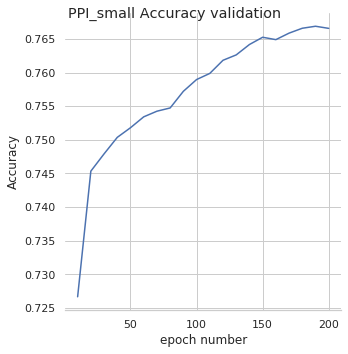

In [87]:
# investigate validation, scatter the tasks among validation batches
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_investigate_validation_scatter_distr(intermediate_data_folder, tune_param_name, tune_val_label, tune_val, 
                                                 trainer_id = trainer_id, model_epoch = res_model_epoch_list, batch_ids = validation_batch_ids)
        
# investigate validation, aggregate results from distributed validation results
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_investigate_validation_aggr_distr(intermediate_data_folder, tune_param_name, tune_val_label, tune_val,
                                              trainer_id = trainer_id, model_epoch = res_model_epoch_list, batch_ids = validation_batch_ids)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    step51_run_investigation_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_label, tune_val,
                                    train_batch_num, net_layer_num, trainer_list, res_model_epoch_list)

### Test investigate

In [88]:
# investigate test, scatter the tasks among test batches
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_test_tuning_scatter_distr(intermediate_data_folder, res_model_epoch_list, tune_param_name, tune_val_label, tune_val, 
                                      trainer_id = trainer_id, batch_ids = test_batch_ids)
        
# investigate test, aggregate results from distributed test results
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_test_tuning_aggr_distr(intermediate_data_folder, tune_param_name, tune_val_label, tune_val, 
                                   trainer_id = trainer_id, batch_ids = test_batch_ids)

Start running training for partition num: 8


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

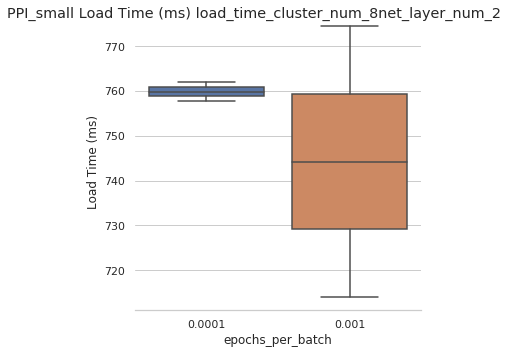

In [89]:
step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_label_list, tune_val_list,
                                train_batch_num, net_layer_num, trainer_list)

### Output Training loss convergence


In [ ]:
# output for the train loss
subfolder = 'GCN_tuning/tune_batch_epoch_num_5/'
check_train_loss_converge(image_data_path, intermediate_data_folder, subfolder, data_name, trainer_id = 0)

In [ ]:
from GraphSaint_dataset import print_data_info, Flickr, Yelp, PPI_large, Amazon, Reddit
# suppose this is on the OSC cluster
remote_data_root = '/home/xiangli/projects/tmpdata/GCN/GraphSaint/'

data_name = 'Flickr'
dataset = Flickr(root = remote_data_root + data_name)
print('number of data', len(dataset))
data = dataset[0]
print_data_info(data, dataset)

In [ ]:
# another way to create class object from a string class name using eval():
data_name = 'Flickr'
data_class = eval(data_name)
print(data_class)
dataset = data_class(root = remote_data_root + data_name)
print('number of data', len(dataset))
data = dataset[0]
print_data_info(data, dataset)

### Appendix

In [ ]:
# free GPU memory
!(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)
# torch.cuda.empty_cache()